<a href="https://colab.research.google.com/github/EsserMishelle/short-term-stock-forecast/blob/main/03_facebook_prophet_univariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facebook Prophet

## Objective
The objective of this project is to forecast the short-term closing price of NVIDIA (NVDA) stock using classical time-series models and compare their performance using information criteria and forecast accuracy.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet

import seaborn as sns
import os
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load NVDA price and volume and merge them together

In [3]:
# --- Load the price file ---
price_df = pd.read_csv(
    '/content/drive/MyDrive/stocks/stock_price_2021_2026.csv',
    index_col='Date',
    parse_dates=True
)

df = price_df[[('NVDA_Close')]].copy()

# Rename column name
df.columns = ['nvda_close']

display(df.info())
print()

display(df.describe())
print()

display(df.head())
print()
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1278 entries, 2021-01-04 to 2026-02-04
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   nvda_close  1278 non-null   float64
dtypes: float64(1)
memory usage: 20.0 KB


None

,nvda_close
count,1278.000000
mean,69.329726
std,59.103824
min,11.212904
25%,19.515135
50%,42.327452
75%,121.585546
max,207.028473


,nvda_close
Date,
2021-01-04,13.076726
2021-01-05,13.367159
2021-01-06,12.579123
2021-01-07,13.306580
2021-01-08,13.239516


,nvda_close
Date,
2026-01-29,192.509995
2026-01-30,191.130005
2026-02-02,185.610001
2026-02-03,180.339996
2026-02-04,174.190002


In [4]:
# Create Prophet dataset

split_date = pd.to_datetime('2025-02-03')

prophet_nvda = df['nvda_close'].reset_index()
prophet_nvda.columns = ['ds', 'y']

# ensure ds is datetime
prophet_nvda['ds'] = pd.to_datetime(prophet_nvda['ds'])
# prophet_nvda.info()

prophet_train = prophet_nvda[prophet_nvda['ds'] < split_date]
prophet_test  = prophet_nvda[prophet_nvda['ds'] >= split_date]

print("Train max:", prophet_train['ds'].max())
print("Test min :", prophet_test['ds'].min())

Train max: 2025-01-31 00:00:00
Test min : 2025-02-03 00:00:00


### Initialize the Prophet model
Prophet already includes: trend and atomatic changepoints

* Stock prices don't have meaningful daily/weekly seasonality.
* Yearly effects sometimes show up in tax cycles and earning cadence

In [5]:
# Training
# Trained only on TRAIN window
#
prophet_model = Prophet(yearly_seasonality=True,
                        weekly_seasonality=False,
                        daily_seasonality=False)

prophet_model.fit(prophet_train)

### Transform the dataset to Facebook Prophet required format.

In [6]:
test_length = len(prophet_test)
FUTURE_DAYS = 30

periods = test_length + FUTURE_DAYS

# Create future dates
prophet_future = prophet_model.make_future_dataframe(periods=periods, freq='B') #'B' for business days, 120 days

# Predict and generate forecast
prophet_forecast = prophet_model.predict(prophet_future)

display(prophet_forecast.tail())
print()
display(prophet_forecast.head())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1303,2026-02-26,227.008444,186.668266,261.434231,190.210294,262.986539,-1.680398,-1.680398,-1.680398,-1.680398,-1.680398,-1.680398,0.0,0.0,0.0,225.328046
1304,2026-02-27,227.203967,187.511358,261.075149,190.210043,263.404578,-1.711338,-1.711338,-1.711338,-1.711338,-1.711338,-1.711338,0.0,0.0,0.0,225.492629
1305,2026-03-02,227.790537,187.191245,262.247277,190.562411,264.143576,-1.765972,-1.765972,-1.765972,-1.765972,-1.765972,-1.765972,0.0,0.0,0.0,226.024566
1306,2026-03-03,227.986061,188.386435,263.484978,190.523732,264.481544,-1.759153,-1.759153,-1.759153,-1.759153,-1.759153,-1.759153,0.0,0.0,0.0,226.226908
1307,2026-03-04,228.181584,187.344807,263.287796,190.493401,264.817919,-1.734701,-1.734701,-1.734701,-1.734701,-1.734701,-1.734701,0.0,0.0,0.0,226.446883


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-04,18.181035,6.899760,18.939919,18.181035,18.181035,-5.508289,-5.508289,-5.508289,-5.508289,-5.508289,-5.508289,0.0,0.0,0.0,12.672746
1,2021-01-05,18.150576,6.250928,18.277900,18.150576,18.150576,-5.555118,-5.555118,-5.555118,-5.555118,-5.555118,-5.555118,0.0,0.0,0.0,12.595458
2,2021-01-06,18.120116,6.681916,18.061074,18.120116,18.120116,-5.614227,-5.614227,-5.614227,-5.614227,-5.614227,-5.614227,0.0,0.0,0.0,12.505890
3,2021-01-07,18.089657,6.478586,18.138807,18.089657,18.089657,-5.685978,-5.685978,-5.685978,-5.685978,-5.685978,-5.685978,0.0,0.0,0.0,12.403679
4,2021-01-08,18.059198,6.151925,17.738491,18.059198,18.059198,-5.770284,-5.770284,-5.770284,-5.770284,-5.770284,-5.770284,0.0,0.0,0.0,12.288914


In [7]:
prophet_eval = prophet_nvda.merge(
    prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds',
    how='left',
)

Align prophet_train_eval and prophet_test_eval row-by-row

In [8]:
train_mask = prophet_eval['ds'] < prophet_test['ds'].min()
test_mask  = (
    (prophet_eval['ds'] >= prophet_test['ds'].min()) &
    (prophet_eval['ds'] <= prophet_test['ds'].max())
)
prophet_train_eval = prophet_eval[train_mask]
prophet_test_eval  = prophet_eval[test_mask]

In [9]:
train_clean = prophet_train_eval.dropna(subset=['yhat'])
test_clean  = prophet_test_eval.dropna(subset=['yhat'])

print("NaNs in train yhat:", prophet_train_eval['yhat'].isna().sum())
print("NaNs in test yhat:", prophet_test_eval['yhat'].isna().sum())
print("Train rows used:", len(train_clean), " / ", len(prophet_train_eval))
print("Test rows used:", len(test_clean), " / ", len(prophet_test_eval))


NaNs in train yhat: 0
NaNs in test yhat: 0
Train rows used: 1025  /  1025
Test rows used: 253  /  253


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(actual, pred):
  actual = np.array(actual)
  pred = np.array(pred)
  return np.mean(np.abs((actual - pred) / actual)) * 100

mae_train = mean_absolute_error(train_clean['y'], train_clean['yhat'])
mae_test  = mean_absolute_error(test_clean['y'], test_clean['yhat'])

rmse_train = np.sqrt(mean_squared_error(train_clean['y'], train_clean['yhat']))
rmse_test  = np.sqrt(mean_squared_error(test_clean['y'], test_clean['yhat']))

mape_train = mape(train_clean['y'], train_clean['yhat'])
mape_test  = mape(test_clean['y'], test_clean['yhat'])

prophet_metrics = pd.DataFrame({
    'Model': ['Prophet','Prophet'],
    'Set': ['Train','Test'],
    'MAE': [mae_train, mae_test],
    'RMSE': [rmse_train, rmse_test],
    'MAPE': [mape_train, mape_test]
})
prophet_metrics.to_csv('prophet_metrics.csv', index=False)
display(prophet_metrics)

,Model,Set,MAE,RMSE,MAPE
0,Prophet,Train,3.281821,4.576770,9.622086
1,Prophet,Test,28.478841,32.043777,20.556801


#### The Prophet metric has a significant gap between train rmse ≈ 8.07 and test rmse ≈ 18.18. This means Prophet is underfitting the volatility.
#### It captures smooth trend but misses rapid market moves. This is completely normal for Prophet on equities.
#### This model does not respond well to momentum, volatility clusters, regime changes, or market shocks.

### Charting Future 30 Days Forecast

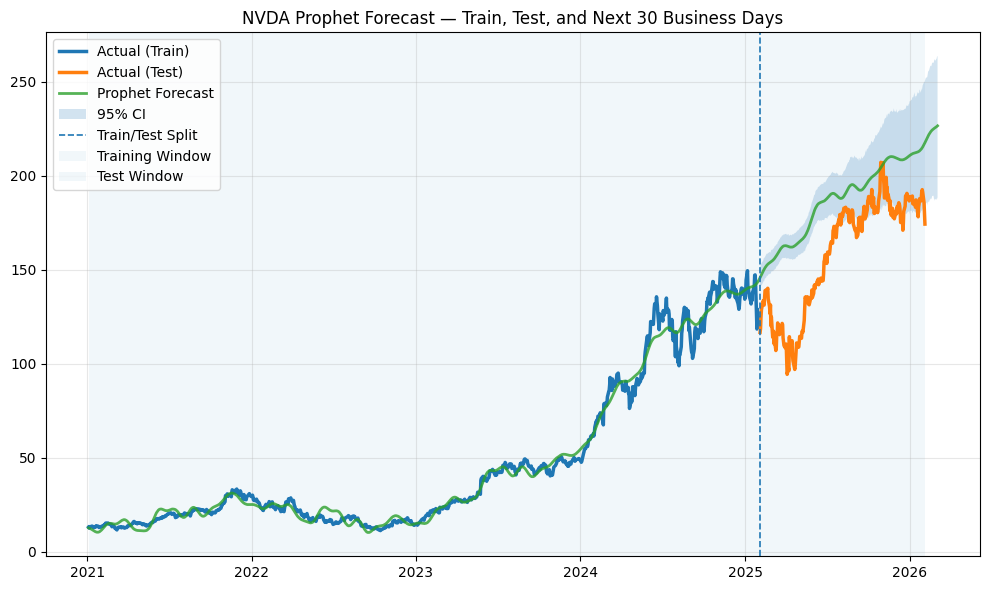

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

split_date = pd.to_datetime('2025-02-03')
train_end  = prophet_train['ds'].max()

plt.figure(figsize=(10,6))



# Actuals
plt.plot(prophet_train['ds'], prophet_train['y'], label='Actual (Train)', linewidth=2.5)
plt.plot(prophet_test['ds'],  prophet_test['y'],  label='Actual (Test)',  linewidth=2.5)

# Forecast
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast', linewidth=2, alpha=0.8)

# Shade uncertainty only AFTER training end (true "future" for the fitted model)
forecast_future = prophet_forecast[prophet_forecast['ds'] > train_end]
plt.fill_between(
    forecast_future['ds'],
    forecast_future['yhat_lower'],
    forecast_future['yhat_upper'],
    alpha=0.2,
    label='95% CI'
)

# Train/Test split marker (fixed)
plt.axvline(split_date, linestyle='--', linewidth=1.2, label='Train/Test Split')

# Window shading (use fixed split)
plt.axvspan(prophet_train['ds'].min(), split_date, alpha=0.06, label='Training Window')
plt.axvspan(split_date, prophet_test['ds'].max(), alpha=0.06, label='Test Window')

plt.title('NVDA Prophet Forecast — Train, Test, and Next 30 Business Days')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


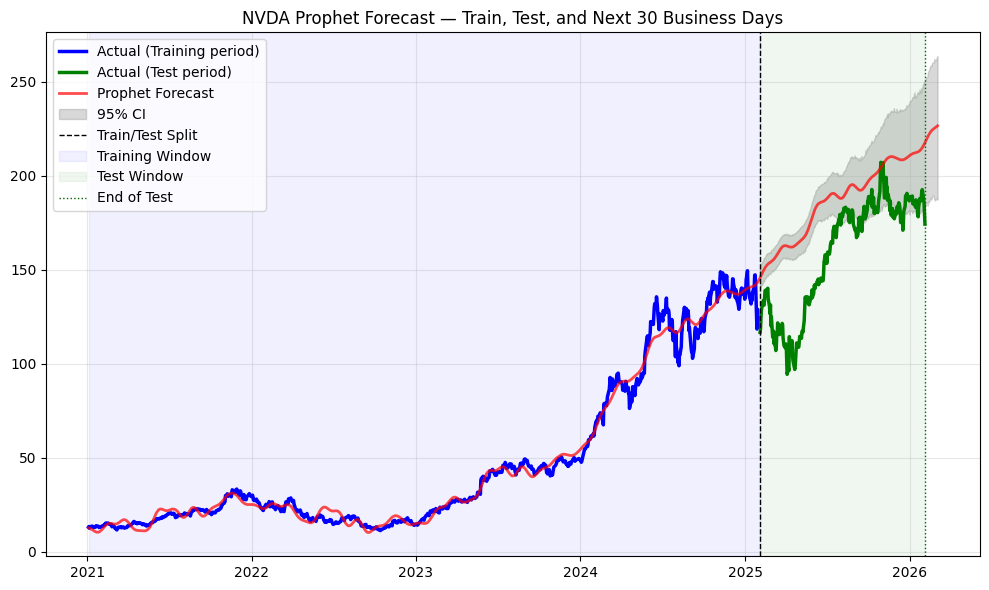

Test window start: 2025-02-03 00:00:00
Test window end:   2026-02-04 00:00:00
Forecast end:      2026-03-04 00:00:00


In [12]:
# Blue and green lines show actual NVDA prices; red line shows Prophet’s predictions.

split_date = pd.to_datetime('2025-02-03')
train_end  = prophet_train['ds'].max()

plt.figure(figsize=(10,6))

# Actual data
plt.plot(prophet_train['ds'], prophet_train['y'],
         label='Actual (Training period)', linewidth=2.5, color='blue')

plt.plot(prophet_test['ds'], prophet_test['y'],
         label='Actual (Test period)', linewidth=2.5, color='green')

# Forecast
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'],
         label='Prophet Forecast', color='red', linewidth=2, alpha=0.7)

# Only shade future uncertainty
# split_date = prophet_train['ds'].max()

forecast_future = prophet_forecast[
    prophet_forecast['ds'] > train_end
]

plt.fill_between(
    forecast_future['ds'],
    forecast_future['yhat_lower'],
    forecast_future['yhat_upper'],
    color='gray',
    alpha=0.3,
    label='95% CI'
)

# Train/Test split line
plt.axvline(
    split_date,
    # x=split_date,
    color='black',
    linestyle='--',
    linewidth=1,
    label='Train/Test Split'
)

plt.title('NVDA Prophet Forecast — Train, Test, and Next 30 Business Days')

plt.axvspan(
    prophet_train['ds'].min(),
    # prophet_train['ds'].max(),
    split_date,
    color='blue',
    alpha=0.06,
    label='Training Window'
)

plt.axvspan(
    split_date,
    # prophet_train['ds'].max(),
    prophet_test['ds'].max(),
    color='green',
    alpha=0.06,
    label='Test Window'
)

plt.axvline(
    x=prophet_test['ds'].max(),
    color='darkgreen',
    linestyle=':',
    linewidth=1,
    label='End of Test'
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print("Test window start:", prophet_test['ds'].min())
print("Test window end:  ", prophet_test['ds'].max())
print("Forecast end:     ", prophet_forecast['ds'].max())

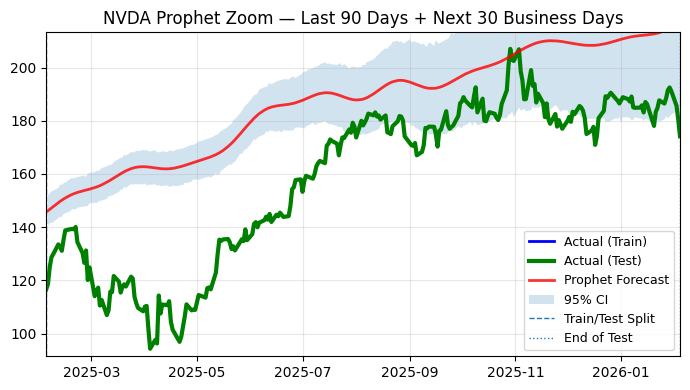

Zoom start: 2025-02-03 00:00:00
Test end: 2026-02-04 00:00:00
Forecast end: 2026-03-04 00:00:00


In [13]:
# ---------- ZOOMED VERSION OF YOUR PROPHET CHART ----------

plt.figure(figsize=(7,4))

test_end = prophet_test['ds'].max()
forecast_end = prophet_forecast['ds'].max()

# Actual data

plt.plot(prophet_train['ds'], prophet_train['y'],
         label='Actual (Train)', linewidth=2, color='blue' )

plt.plot(prophet_test['ds'], prophet_test['y'],
         label='Actual (Test)', linewidth=3, color='green')

plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'],
         label='Prophet Forecast', linewidth=2, alpha=0.8, color='red')

future_only = prophet_forecast[prophet_forecast['ds'] > split_date]
plt.fill_between(
    future_only['ds'],
    future_only['yhat_lower'],
    future_only['yhat_upper'],
    alpha=0.2, label='95% CI'
)

plt.axvline(split_date, linestyle='--', linewidth=1, label='Train/Test Split')
plt.axvline(test_end, linestyle=':', linewidth=1, label='End of Test')

# ----- THIS IS THE ZOOM -----
zoom_start = prophet_test['ds'].min()            # start of last 90 days
zoom_end   = prophet_test['ds'].max()            # end of 30-day forecast
# zoom_end   = forecast_end
plt.xlim(zoom_start, zoom_end)

# Optional: tighten y-axis so the zoom is readable
y_min = prophet_test['y'].min() * 0.97
y_max = prophet_test['y'].max() * 1.03
plt.ylim(y_min, y_max)

# ----- LABELS -----
plt.title('NVDA Prophet Zoom — Last 90 Days + Next 30 Business Days')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Zoom start:", zoom_start)
print("Test end:", test_end)
print("Forecast end:", forecast_end)


## Prophet Summary:

### The result of the prophet metrics demonstrates that a structural decomposition model, such as Facebook Prophet, does not perform as well short horizons.

### These figures show Prophet trained on historical NVDA prices, evaluated on a 90-day test window, and used to generate a 30-business-day forward forecast with 95% confidence intervals. It confirms that Prophet produces a relatively smooth projection that does not capture short-term volatility.